# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
# env_is_google_colab
# 
# True to run the script in Google Colab
# False to run the script in a local environment
# 
env_is_google_colab = True

if env_is_google_colab:
  
  print('Running in a Google Colaboratory environment.')
  
  # Fixes issues with PIL image
  !pip install --no-cache-dir -I pillow

  from os import path
  from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
  platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
  accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'
  !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
    
  from google.colab import drive
  drive.mount('/content/gdrive')
  
  print('Displaying folders and files...')
  
  !ls 'gdrive/My Drive/colab/pytorch_challenge/flower_data'
  !ls 'gdrive/My Drive/colab/pytorch_challenge/flower_data/train/1'
    
else:
  
  print('Running in a local environment.')
  
  
# Imports here
import os

# Main PyTorch library
import torch
# Pytorch Neural Network module
import torch.nn as nn
# Convolution functions
import torch.nn.functional as F
# Optimizatization algorithms
import torch.optim as optim

# Torchvision for image transformation and dataset loading
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision

# from torch.utils.data.sampler import SubsetRandomSampler

# Charts and images visualisation
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image

import numpy as np
import json

Running in a Google Colaboratory environment.
    100% |████████████████████████████████| 2.0MB 36.8MB/s 
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Displaying folders and files...
train  valid
image_06734.jpg  image_06742.jpg  image_06751.jpg  image_06767.jpg
image_06735.jpg  image_06744.jpg  image_06753.jpg  image_06768.jpg
image_06736.jpg  image_06745.jpg  image_06757.jpg  image_06770.jpg
image_06737.jpg  image_06746.jpg  image_06759.jpg  image_06771.jpg
image_06738.jpg  image_06747.jpg  image_06761.jpg  image_06772.jpg
image_06740.jpg  image_06748.jpg  image_06762.jpg  image_06773.jpg
image_06741.jpg  image_06750.jpg  image_06766.jpg


In [2]:
# General definitions

# Use square images of size (image_size x image_size)
image_resize = 256
image_size = 224


# Values you used for normalizing the images. Default here are for 
# pretrained models from torchvision.
normalize_mean = [0.485, 0.456, 0.406]
normalize_std = [0.229, 0.224, 0.225]


# number of subprocesses to use for data loading
num_workers = 2
# how many samples per batch to load. Community having
# memory issues in colab with large batches
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2


# Dataset url:
#     
#     https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip
#
if env_is_google_colab:
  base_dir = 'gdrive/My Drive/colab/pytorch_challenge'
else:
  base_dir = '.'
  
data_dir = base_dir + '/flower_data'

model_checkpoint_path = base_dir + '/model_flowers.pth'

json_file_name = base_dir + '/cat_to_name.json'

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()
if train_on_gpu:
    print("Training on GPU")
else:
    print("Training on CPU")

Training on GPU


## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). You can [download the data here](https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip). The dataset is split into two parts, training and validation. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. If you use a pre-trained network, you'll also need to make sure the input data is resized to 224x224 pixels as required by the networks.

The validation set is used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks available from `torchvision` were trained on the ImageNet dataset where each color channel was normalized separately. For both sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.

In [3]:
# TODO: Define your transforms for the training and validation sets
# Training dataset. Augment the data set to help avoid overfiting
data_transforms = {
    'train': transforms.Compose([
        # Center crop, all images the same size
        transforms.RandomResizedCrop(image_size),
        # Augment the dataset to improve translation invariance
        transforms.RandomHorizontalFlip(),
        # Augment the dataset to improve rotation invariance
        transforms.RandomRotation(12),

        # Tensors can be moved to GPU for faster calculations
        transforms.ToTensor(),

        # Normalize the data as ImageNet expects (If using transfer learning)
        transforms.Normalize(normalize_mean, normalize_std)
    ]),
    'valid': transforms.Compose([
        # First resize to approximate the image size to the desired size
        transforms.Resize(image_resize),
        # Center crop, all images the same size
        transforms.CenterCrop(image_size),

        # Tensors can be moved to GPU for faster calculations
        transforms.ToTensor(),

        # Normalize the data as ImageNet expects (If using transfer learning)
        transforms.Normalize(normalize_mean, normalize_std)
    ]),
}

image_datasets = {
    x: datasets.ImageFolder(
        os.path.join(data_dir, x),
        data_transforms[x]
    )
    for x in ['train', 'valid']
}

dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], 
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers
    )
    for x in ['train', 'valid']
}

dataset_sizes = {
    x: len(image_datasets[x])
    for x in ['train', 'valid']

}
print('Datasets length: ', dataset_sizes)

# PyTorch extracts the class from the folder containing the image
class_names = image_datasets['train'].classes
print('Some class names from folders: ', class_names[:10])

Datasets length:  {'train': 6552, 'valid': 818}
Some class names from folders:  ['1', '10', '100', '101', '102', '11', '12', '13', '14', '15']


### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [4]:
with open(json_file_name, 'r') as f:
    cat_to_name = json.load(f)
    
print('Displaying a random label...')
print(cat_to_name.get(str(21)))

Displaying a random label...
fire lily


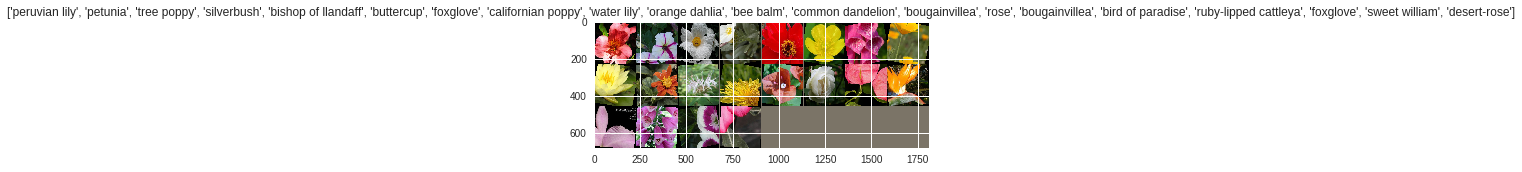

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = normalize_std * inp + normalize_mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[cat_to_name.get(str(class_names[x])) for x in classes])

# 
# If the following error occurs, while running in Google Colab, restart the runtime
#   
#   AttributeError: module 'PIL.Image' has no attribute 'register_extensions'
#     


# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

In [0]:
def create_model():
    
    model = models.vgg19(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    
    # Get the current number of input features
    num_features = model.classifier[6].in_features

    # Freeze the pre-loaded network feature parameters so we don't update it's weights
    for param in model.features.parameters():
        param.requires_grad = False

    # Remove last pre trained layer to be replaced with our classifier
    classifier = list(model.classifier.children())[:-1]
    # Adds out own classifier, with the same input features as before and 
    # our number of classes
    classifier.extend([nn.Linear(num_features, len(class_names))])
    # Replace the model classifier
    model.classifier = nn.Sequential(*classifier)
    
    return model


In [7]:
model = create_model()
print(model.classifier)
model

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.torch/models/vgg19-dcbb9e9d.pth
100%|██████████| 574673361/574673361 [00:07<00:00, 77213196.37it/s]


Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace)
  (2): Dropout(p=0.5)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace)
  (5): Dropout(p=0.5)
  (6): Linear(in_features=4096, out_features=102, bias=True)
)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

In [0]:
# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()


In [0]:
# Loss function
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [0]:
# Each epoch pass over all the data set once
n_epochs = 30

# Validation loss
valid_loss_min = np.Inf

for epoch in range(1, n_epochs+1):

    # Keeps track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    # Trains the model
    model.train()
    n_batch = 1
    print('Train data loader length: ', len(dataloaders['train']))
    for data, target in dataloaders['train']:
      
        if n_batch % 50 == 0:
          print('Training: ', n_batch)
          
        n_batch += 1
        
        # Moves tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()

        # Clears the gradients from previous training steps
        optimizer.zero_grad()
        
        # Feed forward, training step
        output = model(data)
        
        # Calculates the loss
        loss = criterion(output, target)
        
        # Calculates new gradients to be back propagated to the model
        loss.backward()
        
        # Back propagates new weights
        optimizer.step()
        
        # Update training loss
        train_loss += loss.item()*data.size(0)

          
    # Validates the model
    model.eval()
    n_batch = 1
    for data, target in dataloaders['valid']:
      
        if n_batch % 50 == 0:
          print('Evaluating: ', n_batch)
          
        # Moves tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
            
        output = model(data)
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)
    
    # Calculate average losses
    train_loss = train_loss/len(dataloaders['train'].dataset)
    valid_loss = valid_loss/len(dataloaders['valid'].dataset)
        
    # Prints training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # Saves model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))

        valid_loss_min = valid_loss

        # Saves the model
        torch.save({'arch': 'vgg19',
                    'state_dict': model.state_dict(), 
                    'class_to_idx': image_datasets['train'].class_to_idx}, 
                    model_checkpoint_path)
        


Len train data loader:  328
Training:  50
Training:  100
Training:  150
Training:  200
Training:  250
Training:  300
Epoch: 1 	Training Loss: 3.421860 	Validation Loss: 2.297599
Validation loss decreased (inf --> 2.297599).  Saving model ...
Len train data loader:  328
Training:  50
Training:  100
Training:  150
Training:  200
Training:  250
Training:  300
Epoch: 2 	Training Loss: 2.317120 	Validation Loss: 1.716788
Validation loss decreased (2.297599 --> 1.716788).  Saving model ...
Len train data loader:  328
Training:  50
Training:  100
Training:  150
Training:  200
Training:  250
Training:  300
Epoch: 3 	Training Loss: 1.944484 	Validation Loss: 1.433472
Validation loss decreased (1.716788 --> 1.433472).  Saving model ...
Len train data loader:  328
Training:  50
Training:  100
Training:  150
Training:  200
Training:  250
Training:  300
Epoch: 4 	Training Loss: 1.781895 	Validation Loss: 1.274491
Validation loss decreased (1.433472 --> 1.274491).  Saving model ...
Len train data lo

## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [0]:
# TODO: Save the checkpoint 
# This step is done every time we hit a new lower validation loss in the training loop


## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [0]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
def load_model(file_path):

    checkpoint = torch.load(file_path)
    
    model = create_model()
    
    model.load_state_dict(checkpoint['state_dict'])
    model.class_to_idx = checkpoint['class_to_idx']
    model.idx_to_class = {val: key for key, val in model.class_to_idx.items()}
    
    return model

In [70]:
model = load_model(model_checkpoint_path)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

In [71]:
# Along with the model we saved the array that matches classes with indices
print(model.class_to_idx)
print(model.idx_to_class)

{'1': 0, '10': 1, '100': 2, '101': 3, '102': 4, '11': 5, '12': 6, '13': 7, '14': 8, '15': 9, '16': 10, '17': 11, '18': 12, '19': 13, '2': 14, '20': 15, '21': 16, '22': 17, '23': 18, '24': 19, '25': 20, '26': 21, '27': 22, '28': 23, '29': 24, '3': 25, '30': 26, '31': 27, '32': 28, '33': 29, '34': 30, '35': 31, '36': 32, '37': 33, '38': 34, '39': 35, '4': 36, '40': 37, '41': 38, '42': 39, '43': 40, '44': 41, '45': 42, '46': 43, '47': 44, '48': 45, '49': 46, '5': 47, '50': 48, '51': 49, '52': 50, '53': 51, '54': 52, '55': 53, '56': 54, '57': 55, '58': 56, '59': 57, '6': 58, '60': 59, '61': 60, '62': 61, '63': 62, '64': 63, '65': 64, '66': 65, '67': 66, '68': 67, '69': 68, '7': 69, '70': 70, '71': 71, '72': 72, '73': 73, '74': 74, '75': 75, '76': 76, '77': 77, '78': 78, '79': 79, '8': 80, '80': 81, '81': 82, '82': 83, '83': 84, '84': 85, '85': 86, '86': 87, '87': 88, '88': 89, '89': 90, '9': 91, '90': 92, '91': 93, '92': 94, '93': 95, '94': 96, '95': 97, '96': 98, '97': 99, '98': 100, '99'

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [0]:
def process_image(img_path):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model
    
    image = Image.open(img_path).convert('RGB')
    # print(image.size)
    
    # large images will slow down processing
    if max(image.size) > image_size:
        size = image_size
    else:
        size = max(image.size)
        
    in_transform = transforms.Compose([
        # First resize to approximate the image size to the desired size
        transforms.Resize(image_resize),
        # Center crop, all images the same size
        transforms.CenterCrop(image_size),
        # Tensors can be moved to GPU for faster calculations
        transforms.ToTensor(),
        # Normalize the data as ImageNet expects (If using transfer learning)
        transforms.Normalize(normalize_mean, normalize_std)
    ])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

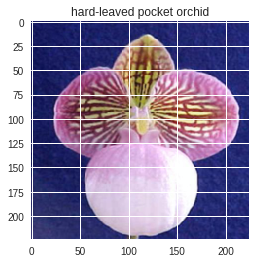

In [23]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.view(3, image_size, image_size)
    # print(image.shape)
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    image = normalize_std * image + normalize_mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.set_title(title)
    ax.imshow(image)
    
    return ax

imshow(process_image(base_dir + '/flower_data/valid/2/image_05094.jpg'), title=cat_to_name.get(str(2)))

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [79]:

def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    image = process_image(image_path)
    # imshow(image)
    
    probs = torch.exp(model(image))
    top_probs, top_idx = probs[0].topk(topk)
      
    top_classes = [model.idx_to_class.get(i.item()) for i in top_idx]
    
    return top_probs.detach().numpy(), top_classes
    
top_probs, top_classes = predict(base_dir + '/flower_data/valid/1/image_06739.jpg', model, 5)
# top_probs, top_classes = predict(base_dir + '/flower_data/valid/2/image_05094.jpg', model, 5)

print('Top probabilities: ')
print(top_probs)

print('Top labels/classes: ')
print(top_classes)


Top probabilities: 
[4774.0312 1926.1752 1551.9525  756.1751  676.7675]
Top labels/classes: 
['1', '89', '51', '60', '97']


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the validation accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

[49923.82   24770.479  19398.436   2906.397   1090.0444]
['1', '51', '19', '86', '60']


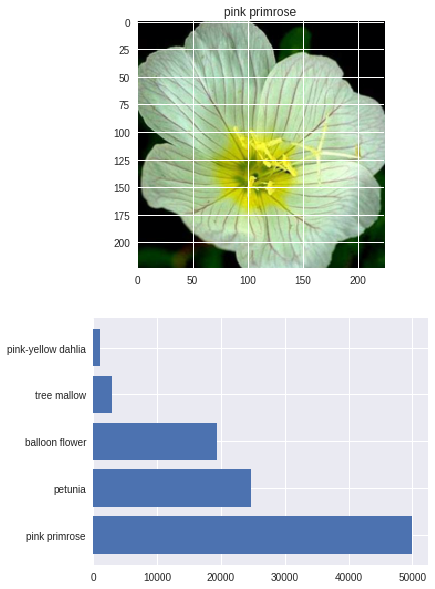

[5.5596358e+08 5.9001336e+04 8.9981260e+03 4.7146919e+03 1.2360294e+03]
['2', '52', '67', '62', '102']


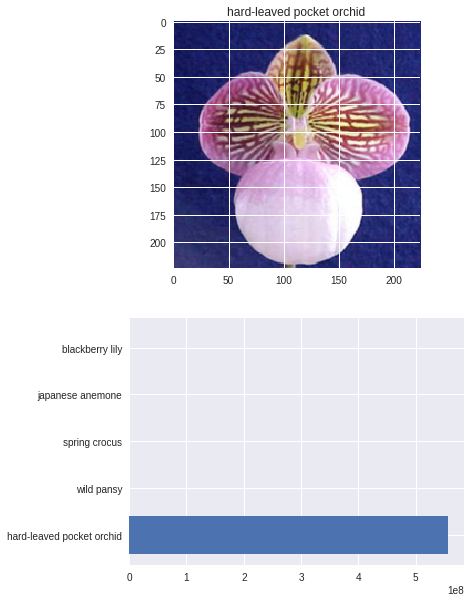

In [82]:
# TODO: Display an image along with the top 5 classes
def plot_solution(image_path, model):

    plt.figure(figsize = (6,10))
    ax = plt.subplot(2,1,1)
    
    # Set up title
    flower_num = image_path.split('/')[-2]
    title = cat_to_name.get(str(flower_num))
    
    img = process_image(image_path)
    imshow(img, ax, title)

    top_probs, top_classes = predict(image_path, model) 
    
    print(top_probs)
    print(top_classes)
    
    class_names = [cat_to_name.get(str(c)) for c in top_classes]
    y_pos = np.arange(len(class_names))

    plt.subplot(2,1,2)
    plt.barh(y_pos, top_probs)
    plt.yticks(y_pos, class_names)
    plt.show()
    
plot_solution(base_dir + '/flower_data/valid/1/image_06739.jpg', model)
plot_solution(base_dir + '/flower_data/valid/2/image_05094.jpg', model)